<center><h1>Step 0 - Preprocessing</h1></center> 

In this section, we first read the data including the bug reports and source code files of all 12 projects and for ease of access, we save them as two pickle files in the ./Output directory. Therefore, this set of code will populate the ./Output directory with "allBugReports.pickle" which is a pandas dataframe that contains all the bug reports from all projects and "allSourceCodes.pickle" which is a pandas dataframe that contains all source files after preprocessing.

### Required Libraries

In [1]:
!pip install javalang

In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import warnings
import javalang
import re
import glob
import math
import time
import xml.etree.ElementTree as ET
import requests
from tqdm.notebook import tqdm as tq
from time import gmtime, strftime
from random import randint
warnings.simplefilter(action='ignore', category=FutureWarning)

<center><h1>Splitting code and natural language</h1></center> 

<center><h1>Loading source codes into pandas Dataframe</h1></center> 

In [3]:
def classNames_methodNames(node):
    result=''
    if isinstance(node,javalang.tree.MethodDeclaration) or isinstance(node,javalang.tree.ClassDeclaration):
        return node.name.lower()+' '
    if not (isinstance(node,javalang.tree.PackageDeclaration) or
        isinstance(node,javalang.tree.FormalParameter) or
       isinstance(node,javalang.tree.Import)):
        if node:
            if isinstance(node, javalang.ast.Node):
                for childNode in node.children:
                    result+=classNames_methodNames(childNode)
    return result
    
def traverse_node(node,i=0):
    i+=1
    result=''
    if not(isinstance(node,javalang.tree.PackageDeclaration)
            or isinstance(node,javalang.tree.FormalParameter)            
            or isinstance(node,javalang.tree.Import)
            or isinstance(node,javalang.tree.CompilationUnit)):
        if node:
            if (isinstance(node,int) or isinstance(node,str) or isinstance(node,float)) and i==2:
                result+=node+' '
            if isinstance(node, javalang.ast.Node):
                for childNode in node.children:
                    result+=traverse_node(childNode,i)
    return result

def code_parser(code):
    try:
        tree = javalang.parse.parse(code)
        return ''.join([traverse_node(node) for path, node in tree]) + ' ' + ''.join([classNames_methodNames(node)
                                                                                      for path, node in tree])
    except Exception as e: 
        print(e)
        return ''

def loadSourceFiles2df(PATH,project):
    """
    Receives: group name and project name 
    Process: open the source file directory and finds all the java files,
             and after preprocessing(using code_preprocessor) load them into a pandas dataframe 
    Returns: dataframe >> "filename","code","size"
    """
    print('Loading source files of {}  ...'.format(project))
    PATH=os.path.join("data",project,"gitrepo")
    all_source_files=glob.glob(PATH+'/**/*.java', recursive=True)
    source_codes_df=pd.DataFrame([])
    sourceCodesList=[]

    for filename in tq(all_source_files):
        code=open(filename,encoding='ISO-8859-1').read()
        if 'src/' in filename:
            sourceCodesList.append(dict({"filename":filename.split('src/')[1].replace('/','.').lower(),
                                         "unprocessed_code":code,
                                         'project':project}))
        else:
            sourceCodesList.append(dict({"filename":filename.split(project)[1].replace('/','.').lower(),
                                         "unprocessed_code":code,
                                         'project':project}))
    source_codes_df=source_codes_df.append(pd.DataFrame(sourceCodesList))
    return source_codes_df

def load_all_SCs(dataPath):
    print('\tLoading all source codes ... ')
    source_codes_df=pd.DataFrame([])
    all_projects= [folder for folder in listdir(dataPath)]
    for project in all_projects:
        source_path=os.path.join(dataPath,project,"gitrepo")
        source_codes_df=source_codes_df.append(loadSourceFiles2df(source_path,project))
    return source_codes_df

<center><h1>Loading bug reports pandas Dataframe</h1></center> 

In [4]:
def loadBugs2df(PATH,project):
    """
    @Receives: the path to bug repository (the xml file)
    @Process: Parses the xml file and reads the fix files per bug id. 
    @Returns: Returns the dataframe
    """
    print("Loading Bug reports ... ")
    all_bugs_df=pd.DataFrame([],columns=["id","fix","text","fixdate"])
    bugRepo = ET.parse(PATH).getroot()
    buglist=[]                   
    for bug in tq(bugRepo.findall('bug')):
        bugDict=dict({"id":bug.attrib['id'],"fix":[],"fixdate":bug.attrib['fixdate']
                      ,"summary":None,"description":None,"project":project,"average_precision":0.0})
        for bugDetail in bug.find('buginformation'):
            if bugDetail.tag=='summary':
                bugDict["summary"]=bugDetail.text
            elif bugDetail.tag=='description':
                bugDict["description"]=bugDetail.text
        bugDict["fix"]=np.array([fixFile.text.replace('/','.').lower() for fixFile in bug.find('fixedFiles')])
        summary=str(bugDict['summary']) if str(bugDict['summary']) !=np.nan else ""
        description=str(bugDict['description']) if str(bugDict['description']) !=np.nan else ""
        buglist.append(bugDict)
    all_bugs_df=all_bugs_df.append(pd.DataFrame(buglist))
    return all_bugs_df.set_index('id')

def load_all_BRs(dataPath):
    print('\tLoading all bug reports ... ')
    all_bugs_df=pd.DataFrame([])
    all_projects= [folder for folder in listdir(dataPath)]
    for project in all_projects:
        data_path=os.path.join(dataPath,project,"bugrepo","repository.xml")
        all_bugs_df=all_bugs_df.append(loadBugs2df(data_path,project))
        print(len(all_bugs_df))
    return all_bugs_df


<center><h1>Main Preprocessing class</h1></center> 

In [5]:
class PreprocessingUnit:
    all_projects_source_codes=pd.DataFrame([])
    all_projects_bugreports=pd.DataFrame([])
    
    def __init__(self,dataPath):
        self.dataPath=dataPath
        self.dataFolder=os.path.join(os.getcwd(),'Output')
        if not os.path.exists(self.dataFolder):
            os.makedirs(self.dataFolder)
            
    def execute(self):
        self.loadEverything()

    def loadEverything(self):
        vectorize=False
        if PreprocessingUnit.all_projects_bugreports.empty:
            bugReportFile=os.path.join(self.dataFolder,'allBugReports.pickle')
            if not os.path.isfile(bugReportFile):
                PreprocessingUnit.all_projects_bugreports=load_all_BRs(dataPath=self.dataPath)
                vectorize=True
                PreprocessingUnit.all_projects_bugreports.to_pickle(bugReportFile)
            else: 
                PreprocessingUnit.all_projects_bugreports=pd.read_pickle(bugReportFile)
        print("*** All bug reports are are preprocessed and stored as: {} ***".format('/'.join(bugReportFile.split('/')[-2:])))

        if PreprocessingUnit.all_projects_source_codes.empty:
            sourceCodeFile=os.path.join(self.dataFolder,'allSourceCodes.pickle')
            if not os.path.isfile(sourceCodeFile):
                PreprocessingUnit.all_projects_source_codes=load_all_SCs(dataPath=self.dataPath)
                vectorize=True
                PreprocessingUnit.all_projects_source_codes.to_pickle(sourceCodeFile)
            else:
                PreprocessingUnit.all_projects_source_codes=pd.read_pickle(sourceCodeFile)
        print("*** All source codes are preprocessed and stored as: {} ***".format('/'.join(sourceCodeFile.split('/')[-2:])))
        

### MAIN

In [6]:
if __name__=="__main__":
    config={'DATA_PATH':os.path.join('data')}
    preprocessor=PreprocessingUnit(dataPath=config['DATA_PATH'])
    preprocessor.execute()

*** All bug reports are are preprocessed and stored as: Output/allBugReports.pickle ***
*** All source codes are preprocessed and stored as: Output/allSourceCodes.pickle ***


In [7]:
def loadEverything():
    all_projects_bugreports = pd.read_pickle('Output/allBugReports.pickle')
    print("*** All Bug Reports are Loaded. ***")
    all_projects_source_codes = pd.read_pickle('Output/allSourceCodes.pickle')
    print("*** All Source Codes are Loaded. ***")
    return all_projects_bugreports, all_projects_source_codes

all_projects_bugreports, all_projects_source_codes = loadEverything()
display(len(all_projects_bugreports))
display(len(all_projects_source_codes))



*** All Bug Reports are Loaded. ***
*** All Source Codes are Loaded. ***


1858

10461

# Problem

There are several software engineering (SE) problems that can be investigated using machine learning. Among them, we will be working on a problem called "Fault Localization" (FL). The goal of FL is to automatically locate a fault entity (e.g. a source file, a class, a method, etc) in source code. There are different variations of FL and we will focus on Information Retrieval based FL (IRFL). This article explains FL: https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=2530&context=sis_research

In short, the idea is, given a new bug report document, we want to automatically identify the source code file that most likely needs a fix, so we can save time for debugging. 

To do this, we may use the previous bug resports and identify the locations (files) that have been patched as our training set. So, we build an IRFL model that:

- Finds the textual similarity between the new bug report and the historical ones. 
- Then rank historically patched source files based on how similar their bug reports are to the new bug report.

# Let's import some things that will help us

In [8]:
# Key Imports
import re

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial import distance
from collections import defaultdict

import multiprocessing as mp
from copy import deepcopy

import matplotlib.pyplot as plt

# Download some stuff to run the code
nltk.download('punkt')
nltk.download('stopwords')

cores = mp.cpu_count()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/justintijunelis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justintijunelis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Pre-processing

First, we need to create our training set. Using `all_projects_bug_reports` and `all_projects_source_codes`.

We will clean the bug report and source code text by creating a function that:

1. Makes all text lowercase
2. Removes all punctuation from the text
3. Removes all repetitive white space from the text
4. Tokenizes the filtered string and removes stem words

Then, we will extract the features and labels of the bug report by:

1. Concatenating the bug summary and description, then using the 

In [9]:
def clean_text(text):
  # Remove imports
  text = re.sub(r"import\s.*;", "", text)
  # Remove packages
  text = re.sub(r"package\s.*;", "", text)
  # Space out camel case (https://stackoverflow.com/questions/5020906/python-convert-camel-case-to-space-delimited-using-regex-and-taking-acronyms-in)
  text = re.sub(r"((?<=[a-z])[A-Z]|(?<!\A)[A-Z](?=[a-z]))", r" \1", text)
  # Replace punctuation with spaces (https://stackoverflow.com/questions/68590438/replace-punctuation-with-space-in-text)
  text = re.sub(r"(?:[^\w\s]|_)+", " ", text)
  # Replace white space or repeating whitespace with single space
  text = re.sub("\s+", " ", text) 
  # Remove all numbers
  text = re.sub(r"[0-9]+", "", text)
  # Remove HTML tags? # Remove static, int, char, etc
  
  # Make everything lowercase
  text = text.lower()

  # Tokenize the words and remove all stop words, ensure no punctuation goes though
  banned_tokens = ["copyright", "void"]
  tokenized = word_tokenize(text) 
  tokens = []
  for token in tokenized:
    if token not in stopwords.words('english') and token not in banned_tokens:
      tokens.append(token)

  # Stem all words using Porter Stemming
  stemmer = PorterStemmer()
  tokens = [stemmer.stem(token) for token in tokens]

  # Recreate the text
  return " ".join(tokens)

def process_bug_reports(bug_reports):
  for row, bug_report in bug_reports.iterrows():
    description = bug_report['description']
    summary = bug_report['summary']
    bug_text = ""
    if isinstance(description, str):
      bug_text += description
    if isinstance(summary, str):
      bug_text += summary
    bug_text = clean_text(bug_text)

    # Skip and delete the row if the bug text is empty
    if bug_text == "":
      bug_reports.drop(row, inplace = True)
    else:
      bug_reports.at[row, 'text'] = bug_text
  bug_reports.drop('summary', axis = 1, inplace = True)
  bug_reports.drop('description', axis = 1, inplace = True)
  return bug_reports

def process_source_files(source_files):
  source_files['unprocessed_code'] = source_files['unprocessed_code'].apply(lambda t: clean_text(t))
  source_files.rename(columns={"unprocessed_code": "code"}, inplace = True)
  source_files = source_files[source_files['code'] != ""]
  return source_files

Process the bug reports and source files:

In [10]:
if __name__ == "__main__":
  with mp.get_context('fork').Pool(processes = cores) as p:
    bug_reports = pd.concat(
      p.map(
        process_bug_reports, 
        np.array_split(all_projects_bugreports.copy(), cores)
      )
    )
  with mp.get_context('fork').Pool(processes = cores) as p:
    source_files = pd.concat(
      p.map(
        process_source_files, 
        np.array_split(all_projects_source_codes.copy(), cores)
      )
    )

# Method 1
- You preprocess the data to have a clean dataset representing source files (including the buggy ones) and the bug reports. The exact preprocessing choices are ours to make.
- Next, apply the TF-IDF method to calculate the similarity between the new bug report (to locate) and the source code files directly. Unlike BugLocator, we ignore the historical bug reports in this step. The similarity function of Method 1 is called the direct relevancy function.
- Finally, we rank the source files based on their textual similarity to the new bug report and present the results using proper evaluation metrics (such as MAP and MRR).


# Calculating Similarities

Since our dataset has multiple projects, and each project has multiple bug reports, we don't want to compare bug reports with files of a project they don't belong to. So, we will compare a bug report to all the files in its respective project. 

To compute similarity between a bug report and it's project file:

1. Iterate through each file of the bug report's project.
2. Create a TF-IDF vectorizer and fit and transform the file's source code since we want to compare against the source code.
3. Transform the bug report's text with the vectorizer.
4. Compare the similarity of the two resulting vectors using cosine distance.

We will iterate through each bug report and generate its similarity, then return a list of similarities that will implicitely map to each bug report.

In [19]:
def calculate_similarity(bug_report, source_files):
  # Find the similarity score
  vectorizer = TfidfVectorizer()
  source_vector = vectorizer.fit_transform(source_files['code'])
  bug_vector = vectorizer.transform([bug_report['text']])
  similarity_score = cosine_similarity(source_vector, bug_vector)

  # Extract the score
  scores = []
  for score in similarity_score:
    scores.append(score[0])

  # Sort the values
  df = pd.DataFrame()
  df['scores'] = np.array(scores)
  df['files'] = source_files['filename'].values
  df = df.sort_values('scores', ascending = False)

  # Create a tuple array
  tuples = []
  for file, score in zip(df['files'].values, df['scores'].values):
    tuples.append((file, score))
  return tuples

def compute_similarities(bug_reports, source_files):
  for row, bug_report in bug_reports.iterrows():
    similarity = calculate_similarity(bug_report, source_files)
    bug_reports.at[row, 'similarities'] = similarity
  return bug_reports


Compute the similarities:

In [20]:
if __name__ == "__main__":
  project_bug_reports = [group for _, group in bug_reports.groupby('project')]
  project_source_files = [group for _, group in source_files.groupby('project')]
  bug_reports['similarities'] = None
  with mp.get_context('fork').Pool(processes = len(project_bug_reports)) as p:
    bug_reports = pd.concat(
      p.starmap(
        compute_similarities,
        zip(project_bug_reports, project_source_files)
      )
    )

# Let's check the MRR (Mean Reciprocal Rank) scores

Our dataset doesn't quite fit with the MRR formula, so we have to improvise. The MRR formula assumes that there is only one query element for a search set (e.g. for set A, B, C, we have a query of A). Since we have a list of queries (e.g. for a set A, B, C, we have a query A, B), our query is a subset of the search set, rather than an element. 

If our query is A, B and the search set is A, B, C, we expect our MRR to be 1. However, using the formula would give us 3/4. So, what we can do is iterate through each element of the query and calculate an MRR, then, *remove* that query element from the subset. 

It looks something like this:

- Query: A, B -> Search Set: A, B, C
- Calculate MRR for A -> 1/1
- Remove A from the Search Set, which becomes: B, C
- Query A -> Search Set: B, C
- Calculate MRR for B -> 1/1
- Remove B from the Search Set, which becomes: C
- Done
- Calculate Adjusted MRR with: (MRR_A + MRR_B)/2 = 1

BUT, what happens if the query is B, A? We still get an adjusted score of 3/4. To avoid this, we need to *sort* the query to be in the same order as the elements appear in the search set.



The adjusted MRR score for project COLLECTIONS is: 0.181635474532537
The adjusted MRR score for project CONFIGURATION is: 0.1988109179906513
The adjusted MRR score for project DATACMNS is: 0.21650559693725993
The adjusted MRR score for project DATAMONGO is: 0.21413970937635984
The adjusted MRR score for project DATAREST is: 0.1635757733482606
The adjusted MRR score for project ELY is: 0.055999999999999994
The adjusted MRR score for project IO is: 0.2871267623494579
The adjusted MRR score for project LANG is: 0.3710479156695793
The adjusted MRR score for project LDAP is: 0.17233062267846433
The adjusted MRR score for project SEC is: 0.18608322931290394
The adjusted MRR score for project SOCIALFB is: 0.3340073031474654
The adjusted MRR score for project SPR is: 0.09063454469266335


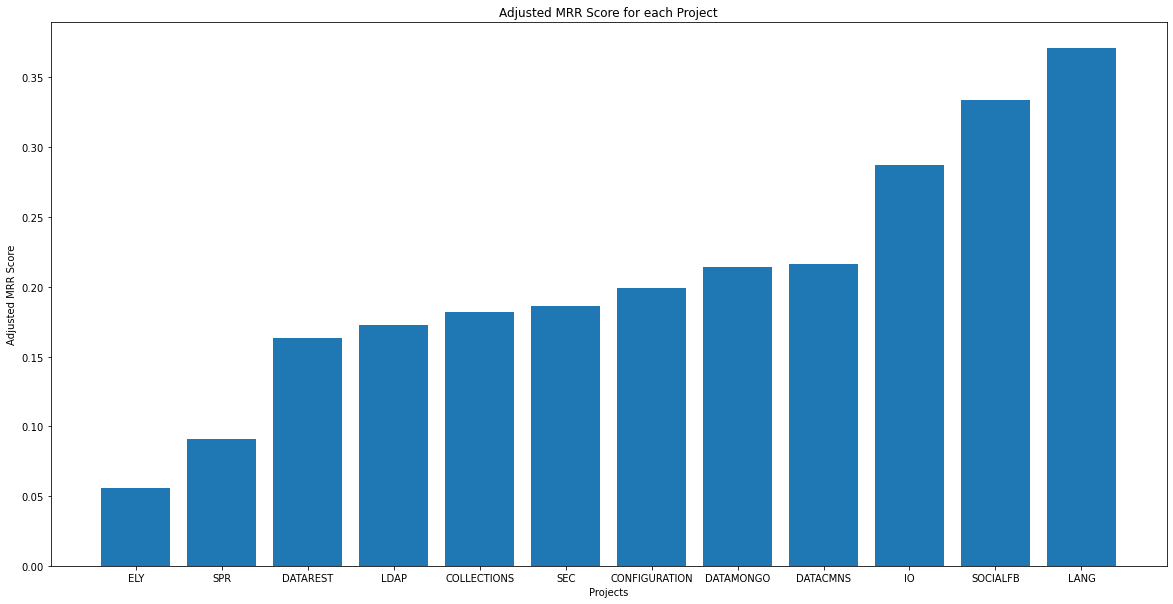

In [21]:
def calculate_adjusted_MRR(bug_report):
  fixed_files = bug_report['fix']
  project_file_similarities = deepcopy(bug_report['similarities'])

  # Sort the fixed files to be in the same order as they appear in the project file similarities
  i = 0
  temp_fixed_files = []
  for similarity in project_file_similarities:
    file = similarity[0]
    if len(temp_fixed_files) == len(fixed_files):
      break
    for f in fixed_files:
      if f in file or f == file:
        temp_fixed_files.append(file)
  if len(temp_fixed_files) != len(fixed_files):
    return 0
  fixed_files = temp_fixed_files

  # Calculate the MRR for the bug report
  adjusted_reciprocals = []
  for fixed_file in fixed_files:
    # Find the ranking of the fixed file in the similarities array
    similarity_index = 1
    for i, similarity in enumerate(project_file_similarities): # check i
      file, _ = similarity
      if file in fixed_file:
        similarity_index = i + 1
        break

    # Calculate the similarity and shift the window
    adjusted_reciprocals.append(1 / similarity_index)
    del project_file_similarities[similarity_index - 1]

  return sum(adjusted_reciprocals)/len(adjusted_reciprocals)

def calculate_adjusted_project_MRRs(bug_reports):
  # Calculate the adjusted MRR for each bug report
  for row, bug_report in bug_reports.iterrows():
    bug_reports.at[row, 'adjusted_MRR'] = calculate_adjusted_MRR(bug_report)

  # Group the project bugs, and compute the net MRR
  project_bug_reports = [group for _, group in bug_reports.groupby('project')]
  project_scores = defaultdict(str)
  projects = bug_reports['project'].unique()
  for project in projects:
    project_scores[project] = 0
  for project, project_bug_report in zip(projects, project_bug_reports):
    print("The adjusted MRR score for project " + project + " is: ", end="")
    score = sum(project_bug_report['adjusted_MRR'])/len(project_bug_report['adjusted_MRR'])
    project_scores[project] = score
    print(score)

  # Create a plot
  project_scores = dict(sorted(project_scores.items(), key=lambda item: item[1]))
  plt.figure(figsize=(20, 10))
  plt.bar(range(len(project_scores)), list(project_scores.values()), tick_label=list(project_scores.keys()))
  plt.xlabel('Projects')
  plt.ylabel('Adjusted MRR Score')
  plt.title('Adjusted MRR Score for each Project')
  plt.show()

calculate_adjusted_project_MRRs(bug_reports)

# Let's calculate the MAP (Mean Average Precision) scores



COLLECTIONS
The MAP score for project COLLECTIONS is: 0.003101668862538427
CONFIGURATION
The MAP score for project CONFIGURATION is: 0.00214551530341004
DATACMNS
The MAP score for project DATACMNS is: 7.308463353057477e-05
DATAMONGO
The MAP score for project DATAMONGO is: 0.0
DATAREST
The MAP score for project DATAREST is: 5.8275058275058275e-05
ELY
The MAP score for project ELY is: 0.0
IO
The MAP score for project IO is: 0.0
LANG
The MAP score for project LANG is: 0.0
LDAP
The MAP score for project LDAP is: 0.0008576329331046312
SEC
The MAP score for project SEC is: 0.0
SOCIALFB
The MAP score for project SOCIALFB is: 0.0015873015873015873
SPR
The MAP score for project SPR is: 0.0009521116138763198


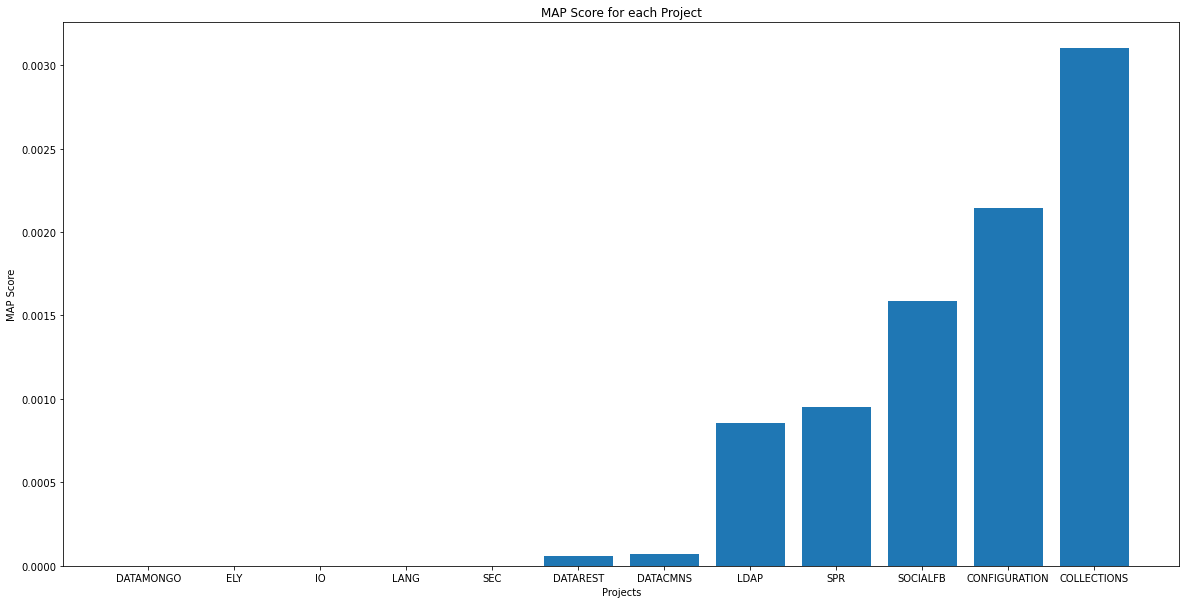

In [14]:
def calculate_average_precision(bug_report):
  fixed_files = bug_report['fix']
  similarities = bug_report['similarities']
  average_precision = []

  # Precompute some queries
  fixed_file_indices = []
  for fix in fixed_files:
    for i in range(len(similarities)):
      if fix in similarities[i][0] or fix == similarities[i][0]:
        fixed_file_indices.append(i)

  for j in range(len(similarities)):
    if j + 1 == len(similarities):
      break

    # Calculate P(j)
    number_of_positive_instances_in_top_j = 0
    for index in fixed_file_indices:
      if index <= j:
        number_of_positive_instances_in_top_j += 1
    p_j = number_of_positive_instances_in_top_j / (j + 1)

    # Calculate pos(j)
    pos_j = 0
    document_j = similarities[j]
    for file in fixed_files:
      if file in document_j[0] or file == document_j[0]:
        pos_j = 1

    average_precision.append((p_j * pos_j) / len(fixed_files))

  return sum(average_precision)

def calculate_adjusted_project_MAP_scores(bug_reports):
  # Calculate the average precision for each bug report
  for row, bug_report in bug_reports.iterrows():
    score = calculate_average_precision(bug_report)
    bug_reports.at[row, 'average_precision'] = score

  # Group the project bugs, and compute the net MAP per project
  project_bug_reports = [group for _, group in bug_reports.groupby('project')]
  project_scores = defaultdict(str)
  projects = bug_reports['project'].unique()
  for project in projects:
    project_scores[project] = 0
  for project_bug_report in project_bug_reports:
    print(project_bug_report['project'][0])
    print("The MAP score for project " + project_bug_report['project'][0] + " is: ", end="")
    score = sum(project_bug_report['average_precision'])/len(project_bug_report['average_precision'])
    project_scores[project_bug_report['project'][0]] = score
    print(score)

  # Create the plot
  project_scores = dict(sorted(project_scores.items(), key=lambda item: item[1]))
  plt.figure(figsize=(20, 10))
  plt.bar(range(len(project_scores)), list(project_scores.values()), tick_label=list(project_scores.keys()))
  plt.xlabel('Projects')
  plt.ylabel('MAP Score')
  plt.title('MAP Score for each Project')
  plt.show()

calculate_adjusted_project_MAP_scores(bug_reports)

# Let's multiprocess the MAP scores

In [15]:
if __name__ == "__main__":
  pass

# Method 2

In this step, we will develop a new IRFL method and comparing to Method 1.

We will roughly implement the BugLocator tool. We will use the same preprocessing as TF-IDF code we developed for method 1 to calculate an indirect relevancy function. Then, we will use a weighted average of the direct relevancy function and indirect relevancy function to do the ranking for this method. The indirect function calculates the similarity between the new bug report and the historical ones. Then, given that we already know which exact files have been fixed for each historical bug report. So, we can map files to historical bug reports. Then, the algorithm ranks source files according to their indirect similarity (the similarity of a source file's corresponding historical report(s) to the new bug report) to the new bug report.

- Method 2 MUST improve method 1 results.
 

# Method 3

This is our brand new FL technique applicable on this dataset. The novel approach should use a machine learning/information retrieval method that is not taught in class. It is okay if the method is already proposed in the FL literature and is published, however, your code cannot be copy-pasted. This method does not need to outperform the other methods.